In [3]:
from diffusers import DiffusionPipeline, DPMSolverMultistepScheduler, PNDMScheduler, UNet2DConditionModel
import torch
from es_dataset import EpidemicSoundDataset
import torch.nn.functional as F
from tqdm import tqdm

import matplotlib.pyplot as plt

In [10]:
# repo_id = "stabilityai/stable-diffusion-2-base"
repo_id = "CompVis/stable-diffusion-v1-4"
pipe = DiffusionPipeline.from_pretrained(repo_id)

# pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


In [3]:
pipe.vae.save_pretrained('/scratch/korte/audiffuse/sd14_ae_ckpt')

In [11]:
pipe.unet.config['cross_attention_dim']

768

In [12]:
pipe.unet.save_pretrained('/scratch/korte/audiffuse/sd_unet_ckpt')

In [16]:
pndm = PNDMScheduler(num_train_timesteps=1000)
pndm.set_timesteps(1000)
print(pndm.timesteps)

tensor([999, 998, 998,  ...,   2,   1,   0])


In [17]:
pipe.scheduler.timesteps

In [6]:
pipe.unet.cross_attention_dim

/local_scratch/pbs.1165141.pbs02/ipykernel_64709/3001686650.py:1: FutureWarning: Accessing config attribute `cross_attention_dim` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'cross_attention_dim' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.cross_attention_dim'.
  pipe.unet.cross_attention_dim


768

In [16]:
prompt = "High quality photo of an astronaut riding a horse in space"
image = pipe(prompt, num_inference_steps=25).images[0]
image.save("astronaut.png")

100%|██████████| 25/25 [00:26<00:00,  1.04s/it]


In [22]:
prompt_embeds = pipe._encode_prompt(
            "Album Art",
            pipe._execution_device,
            1,
            True,
            "",
            prompt_embeds=None,
            negative_prompt_embeds=None,
            lora_scale=None,
        )


In [6]:
pipe = pipe.to('cuda')

In [23]:
prompt_embeds.shape

torch.Size([2, 77, 1024])

In [24]:
model = pipe.unet

In [25]:
dataset = EpidemicSoundDataset('/fastscratch/korte/es_dataset/')

In [26]:
img = dataset[10]['album_art'].to(pipe.device)
song = dataset[10]['audio']

for key in song:
    if isinstance(song[key], torch.Tensor):
        song[key] = song[key].unsqueeze(0).to(pipe.device)

/home/korte/micromamba/envs/ml/lib/python3.9/site-packages/torchaudio/transforms/_transforms.py:611: UserWarning: Argument 'onesided' has been deprecated and has no influence on the behavior of this module.
  warnings.warn(
/home/korte/micromamba/envs/ml/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [27]:
with torch.no_grad():
    model.train()
    pipe.scheduler.set_timesteps(1000)

    latents = pipe.vae.encode(img.unsqueeze(0).to(pipe.device)).latent_dist.sample()
    noise = torch.randn((1, 4, 64, 64)).to(pipe.device)
    latents = pipe.scheduler.add_noise(latents, noise, torch.tensor(20))
    
    # latents = torch.randn((1, 4, 64, 64)).to(model.device)

    input_latents = torch.cat([latents] * 2)
    for t in tqdm(pipe.scheduler.timesteps[-20:]):
        print(latents.shape)
        print(input_latents.shape)
        input_latents = pipe.scheduler.scale_model_input(input_latents, t)
        print(input_latents.shape)
        pred_noise = model(input_latents, t, prompt_embeds).sample
        latents = pipe.scheduler.step(pred_noise, t, latents, return_dict=False)[0]

    images = pipe.vae.decode(latents).sample

  0%|          | 0/20 [00:00<?, ?it/s]

torch.Size([1, 4, 64, 64])
torch.Size([2, 4, 64, 64])
torch.Size([2, 4, 64, 64])


  5%|▌         | 1/20 [00:01<00:25,  1.33s/it]

torch.Size([2, 4, 64, 64])
torch.Size([2, 4, 64, 64])
torch.Size([2, 4, 64, 64])


 10%|█         | 2/20 [00:02<00:21,  1.21s/it]

torch.Size([2, 4, 64, 64])
torch.Size([2, 4, 64, 64])
torch.Size([2, 4, 64, 64])


 15%|█▌        | 3/20 [00:03<00:19,  1.15s/it]

torch.Size([2, 4, 64, 64])
torch.Size([2, 4, 64, 64])
torch.Size([2, 4, 64, 64])


 20%|██        | 4/20 [00:04<00:18,  1.16s/it]

torch.Size([2, 4, 64, 64])
torch.Size([2, 4, 64, 64])
torch.Size([2, 4, 64, 64])


 25%|██▌       | 5/20 [00:05<00:17,  1.13s/it]

torch.Size([2, 4, 64, 64])
torch.Size([2, 4, 64, 64])
torch.Size([2, 4, 64, 64])


 30%|███       | 6/20 [00:07<00:16,  1.16s/it]

torch.Size([2, 4, 64, 64])
torch.Size([2, 4, 64, 64])
torch.Size([2, 4, 64, 64])


 35%|███▌      | 7/20 [00:08<00:15,  1.21s/it]

torch.Size([2, 4, 64, 64])
torch.Size([2, 4, 64, 64])
torch.Size([2, 4, 64, 64])


 40%|████      | 8/20 [00:09<00:14,  1.17s/it]

torch.Size([2, 4, 64, 64])
torch.Size([2, 4, 64, 64])
torch.Size([2, 4, 64, 64])


 45%|████▌     | 9/20 [00:10<00:12,  1.17s/it]

torch.Size([2, 4, 64, 64])
torch.Size([2, 4, 64, 64])
torch.Size([2, 4, 64, 64])


 50%|█████     | 10/20 [00:11<00:11,  1.18s/it]

torch.Size([2, 4, 64, 64])
torch.Size([2, 4, 64, 64])
torch.Size([2, 4, 64, 64])


 55%|█████▌    | 11/20 [00:13<00:10,  1.19s/it]

torch.Size([2, 4, 64, 64])
torch.Size([2, 4, 64, 64])
torch.Size([2, 4, 64, 64])


 60%|██████    | 12/20 [00:14<00:09,  1.17s/it]

torch.Size([2, 4, 64, 64])
torch.Size([2, 4, 64, 64])
torch.Size([2, 4, 64, 64])


 65%|██████▌   | 13/20 [00:15<00:08,  1.15s/it]

torch.Size([2, 4, 64, 64])
torch.Size([2, 4, 64, 64])
torch.Size([2, 4, 64, 64])


 70%|███████   | 14/20 [00:16<00:07,  1.17s/it]

torch.Size([2, 4, 64, 64])
torch.Size([2, 4, 64, 64])
torch.Size([2, 4, 64, 64])


 75%|███████▌  | 15/20 [00:17<00:05,  1.14s/it]

torch.Size([2, 4, 64, 64])
torch.Size([2, 4, 64, 64])
torch.Size([2, 4, 64, 64])


 80%|████████  | 16/20 [00:18<00:04,  1.12s/it]

torch.Size([2, 4, 64, 64])
torch.Size([2, 4, 64, 64])
torch.Size([2, 4, 64, 64])


 85%|████████▌ | 17/20 [00:19<00:03,  1.18s/it]

torch.Size([2, 4, 64, 64])
torch.Size([2, 4, 64, 64])
torch.Size([2, 4, 64, 64])


 90%|█████████ | 18/20 [00:20<00:02,  1.15s/it]

torch.Size([2, 4, 64, 64])
torch.Size([2, 4, 64, 64])
torch.Size([2, 4, 64, 64])


 95%|█████████▌| 19/20 [00:22<00:01,  1.16s/it]

torch.Size([2, 4, 64, 64])
torch.Size([2, 4, 64, 64])
torch.Size([2, 4, 64, 64])


100%|██████████| 20/20 [00:23<00:00,  1.16s/it]


In [28]:
latents.max(), latents.min(), latents.mean(), latents.std()

(tensor(16.1073), tensor(-15.0528), tensor(0.9036), tensor(6.4382))

In [142]:
with torch.no_grad():
    t = 900
    latents = pipe.vae.encode(img.unsqueeze(0).to(model.device)).latent_dist.sample()
    noise = torch.randn((1, 4, 64, 64)).to(model.device)
    latents = pipe.scheduler.add_noise(latents, noise, torch.tensor(t))
    print(latents.shape)
    latents = torch.cat([latents] * 2)
    print(latents.shape)
    latents = pipe.scheduler.scale_model_input(latents, t)
    print(latents.shape)

    pred_noise = model(latents, t, prompt_embeds).sample
    print(F.mse_loss(pred_noise, noise))

torch.Size([1, 4, 64, 64])
torch.Size([2, 4, 64, 64])
torch.Size([2, 4, 64, 64])
tensor(0.1045)


/local_scratch/pbs.1127021.pbs02/ipykernel_17791/391556651.py:13: UserWarning: Using a target size (torch.Size([1, 4, 64, 64])) that is different to the input size (torch.Size([2, 4, 64, 64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  print(F.mse_loss(pred_noise, noise))


In [130]:
img.min()

0.007843137

In [128]:
# img = img.cpu().numpy() * 0.5 + 0.5
# images = images[0].cpu().numpy() * 0.5 + 0.5
# fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(img.transpose(1, 2, 0).clip(0, 1))
axs[0].set_title('Original Image')
axs[1].imshow(images.transpose(1, 2, 0).clip(0, 1))
axs[1].set_title('Generated Image')
plt.show()

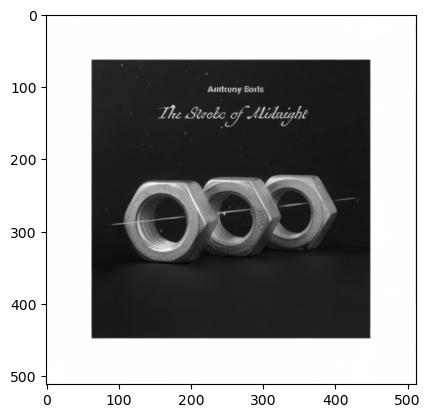

In [135]:
plt.imshow(images.transpose(1, 2, 0).clip(0, 1))
plt.show()